# 1) Serbia

## Calculate urban extents

In [1]:
import geopandas as gpd
import pandas as pd
import sys
import os
sys.path.append(os.path.join(os.path.expanduser("~"), "Repos", "GOST_Urban"))
import src.UrbanRaster as urban
import rasterio as rio
from geopy.geocoders import Nominatim, GeoNames
from affine import Affine

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = os.path.join(os.path.expanduser("~"), "data", "serbia")
wp_dir = os.path.join(data_dir, "wp")

In [4]:
out_dir = os.path.join(data_dir, "output")
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [5]:
os.listdir(wp_dir)[0]

'srb_ppp_2020_1km_Aggregated_UNadj.tif'

In [25]:
wp = rio.open(os.path.join(wp_dir, 'srb_ppp_2020_1km_Aggregated_UNadj.tif'))

In [26]:
urban_calculator = urban.urbanGriddedPop(wp)

In [30]:
urban_extents = urban_calculator.calculateUrban(densVal=300, totalPopThresh=5000, 
                                               smooth=True, queen=False,
                                               verbose=True)

13:41:29	: Read in urban data
13:41:29	: Creating Shape 0


In [55]:
urban_extents.loc[:, "centroid"] = urban_extents.geometry.apply(lambda ext: ext.centroid)
# urban_extents.loc[:, "yx"] = urban_extents.centroid.apply(lambda cent: (cent.y, cent.x))

In [42]:
geolocator = Nominatim(user_agent="new_app")

In [57]:
extents_geocode = {}
for idx, row in urban_extents.iterrows():
    res = geolocator.reverse(query = (row.centroid.y, row.centroid.x), language = "en", zoom = 10)
    extents_geocode[idx] = res

In [58]:
addresses = [l.raw['address'] for l in list(extents_geocode.values())]
# city_districts = [a['city_district'] if 'city_district' in a.keys() else "" for a in addresses]
cities = [a['city'] if 'city' in a.keys() else "" for a in addresses]
counties = [a['county'] if 'county' in a.keys() else "" for a in addresses]
states = [a['state'] if 'state' in a.keys() else "" for a in addresses]

In [60]:
# urban_extents.loc[:, "city_district"] = city_districts
urban_extents.loc[:, "city"] = cities
urban_extents.loc[:, "county"] = counties
urban_extents.loc[:, "state"] = states

In [63]:
urban_extents.drop('centroid', axis=1, inplace=True)

In [64]:
urban_extents.to_file(os.path.join(out_dir, "urban_extents.shp"), driver="ESRI Shapefile", encoding='utf-8')
# urban_extents.to_file(os.path.join(out_dir, "urban_extents.geojson"), driver='GeoJSON', encoding='utf-8')

In [34]:
urban_extents_hd = urban_calculator.calculateUrban(densVal=1500, totalPopThresh=50000, 
                                               smooth=True, queen=False,
                                               verbose=True)

15:03:50	: Read in urban data
15:03:50	: Creating Shape 0


In [40]:
urban_extents_hd.loc[:, "centroid"] = urban_extents_hd.geometry.apply(lambda ext: ext.centroid)
urban_extents_hd.loc[:, "rep_point"] = urban_extents_hd.geometry.apply(lambda ext: ext.representative_point())

In [44]:
extents_geocode = {}
for idx, row in urban_extents_hd.iterrows():
    res = geolocator.reverse(query = (row.centroid.y, row.centroid.x), language = "en", zoom = 10)
    extents_geocode[idx] = res

In [45]:
addresses = [l.raw['address'] for l in list(extents_geocode.values())]
# city_districts = [a['city_district'] if 'city_district' in a.keys() else "" for a in addresses]
cities = [a['city'] if 'city' in a.keys() else "" for a in addresses]
counties = [a['county'] if 'county' in a.keys() else "" for a in addresses]
states = [a['state'] if 'state' in a.keys() else "" for a in addresses]

In [46]:
urban_extents_hd.loc[:, "city"] = cities
urban_extents_hd.loc[:, "county"] = counties
urban_extents_hd.loc[:, "state"] = states

In [47]:
urban_extents_hd.drop('centroid', axis=1, inplace=True)
urban_extents_hd.drop('rep_point', axis=1, inplace=True)

In [48]:
urban_extents_hd.to_file(os.path.join(out_dir, "urban_extents_hd.shp"), driver="ESRI Shapefile", encoding='utf-8')

In [69]:
urban_extents = gpd.read_file(os.path.join(out_dir, "urban_extents.shp"))

In [61]:
urban_extents.drop('geometry', axis=1, inplace=True)

In [63]:
urban_extents.to_csv(os.path.join(out_dir, "urban_extents.csv"), encoding='utf-8')

In [64]:
urban_extents_hd.to_csv(os.path.join(out_dir, "urban_extents_hd.csv"), encoding='utf-8')

## Calculate degree of urbanization

WP data needs to be reprojected for distance threshold.

In [92]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:32634'

with rasterio.open(os.path.join(wp_dir, 'srb_ppp_2020_1km_Aggregated_UNadj.tif')) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(os.path.join(wp_dir, 'srb_ppp_2020_1km_Reproj.tif'), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [93]:
urban_calculator = urban.urbanGriddedPop(os.path.join(wp_dir, 'srb_ppp_2020_1km_Reproj.tif'))

In [94]:
degUrb = urban_calculator.calculateDegurba(out_raster = os.path.join(out_dir, "deg_urb.tif"))

In [96]:
degUrb.keys()

dict_keys(['raster', 'shapes', 'HD', 'URB'])

In [100]:
degUrb['URB']

array([[11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       ...,
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.],
       [11., 11., 11., ..., 11., 11., 11.]], dtype=float32)

## GHS MOD Dataset

In [53]:
# clip from global GHSL file
ghs_tif = "/home/public/Data/GLOBAL/URBAN/GHS/GHS_SMOD/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0.tif"
in_ghs_mod = rio.open(ghs_tif)
if not inB.crs == in_ghs_mod.crs:
    inB = inB.to_crs(in_ghs_mod.crs.to_string())

In [56]:
input_ghs_mod = os.path.join(out_dir, "GHS_MOD.tif")
rMisc.clipRaster(in_ghs_mod, inB, input_ghs_mod)

## Landscape Expansion Index

In [7]:
import os, sys, logging, importlib

import geojson, rasterio
import rasterio.features

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import shape, GeometryCollection
from shapely.wkt import loads
from matplotlib import pyplot
from rasterio.plot import show, show_hist

#Import GOST urban functions
import src.LEI as lei

try:    
    sys.path.append(os.path.join(os.path.expanduser("~"), "Repos", "gostrocks", "src"))
    import GOSTRocks.rasterMisc as rMisc
except:
    print("gostrocks is required to clip GHSL to AOI and warp the WSF to a metres projection")

In [8]:
global_bounds = "/home/public/Data/GLOBAL/ADMIN/Admin0_Polys.shp"
inB = gpd.read_file(global_bounds)
inB = inB.loc[inB['ISO3'] == 'SRB']

In [8]:
# clip from global GHSL file
ghsl_vrt = "/home/public/Data/GLOBAL/GHSL/ghsl.vrt"
in_ghsl = rio.open(ghsl_vrt)
if not inB.crs == in_ghsl.crs:
    inB = inB.to_crs(in_ghsl.crs.to_string())

In [9]:
input_ghsl = os.path.join(out_dir, "GHSL.tif")
# rMisc.clipRaster(in_ghsl, inB, input_ghsl)

In [10]:
%%time
# This calculates the change from 1990 and 2000
lei_raw = lei.calculate_LEI(input_ghsl, old_list = [5,6], new_list=[4])
lei_90_00 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
lei_90_00['LEI'] = lei_90_00['old'] / lei_90_00['total']      
lei_90_00.head()

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2183730 5799630 at 2183730 5799630
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2186820 5793720 at 2186820 5793720
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2121180 5764500 at 2121180 5764500
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2128230 5747370 at 2128230 5747370
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2128140 5742030 at 2128140 5742030
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2128260 5741550 at 2128260 5741550
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2167020 5726940 at 2167020 5726940
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2175810 5718360 at 2175810 5718360
TopologyException: Input geom 1 is invalid: Ring

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2249910 5603100 at 2249910 5603100
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2301840 5602860 at 2301840 5602860
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2262060 5602440 at 2262060 5602440
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2279070 5602320 at 2279070 5602320
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2249430 5601900 at 2249430 5601900
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2279520 5602020 at 2279520 5602020
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2200080 5601480 at 2200080 5601480
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2247660 5601150 at 2247660 5601150
TopologyException: Input geom 1 is invalid: Ring

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256750 5523570 at 2256750 5523570
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2282880 5517780 at 2282880 5517780
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2214060 5509710 at 2214060 5509710
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2508690 5503020 at 2508690 5503020
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2508150 5503080 at 2508150 5503080
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2507310 5501970 at 2507310 5501970
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2327910 5471070 at 2327910 5471070
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2482440 5454000 at 2482440 5454000
TopologyException: Input geom 1 is invalid: Ring

CPU times: user 11min 22s, sys: 12.1 s, total: 11min 34s
Wall time: 11min 33s


,geometry,old,total,LEI
0,"POLYGON ((2228250 5808720, 2228250 5808690, 22...",2,356,0.005618
1,"POLYGON ((2224590 5808600, 2224590 5808570, 22...",25,376,0.066489
2,"POLYGON ((2228400 5808570, 2228400 5808540, 22...",2,376,0.005319
3,"POLYGON ((2224350 5808360, 2224350 5808300, 22...",33,376,0.087766
4,"POLYGON ((2224290 5808300, 2224290 5808240, 22...",32,411,0.077859


In [11]:
# This calculates the change from 2000 and 2014
lei_raw = lei.calculate_LEI(input_ghsl, old_list = [4,5,6], new_list=[3])
lei_00_14 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
lei_00_14['LEI'] = lei_00_14['old'] / lei_00_14['total']      
lei_00_14.head()

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2107350 5762040 at 2107350 5762040
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2108400 5761380 at 2108400 5761380
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2234850 5734500 at 2234850 5734500
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2228460 5715660 at 2228460 5715660
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2190150 5710140 at 2190150 5710140
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2232150 5694660 at 2232150 5694660
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2232030 5694360 at 2232030 5694360
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2255760 5690040 at 2255760 5690040
TopologyException: Input geom 1 is invalid: Ring

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2283570 5595900 at 2283570 5595900
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2267610 5595690 at 2267610 5595690
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2261070 5594340 at 2261070 5594340
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2283480 5593230 at 2283480 5593230
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2280870 5591580 at 2280870 5591580
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2282250 5590830 at 2282250 5590830
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2285550 5590320 at 2285550 5590320
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2266890 5590320 at 2266890 5590320
TopologyException: Input geom 1 is invalid: Ring

,geometry,old,total,LEI
0,"POLYGON ((2224560 5808660, 2224560 5808600, 22...",27,376,0.071809
1,"POLYGON ((2223990 5808570, 2223990 5808510, 22...",0,396,0.000000
2,"POLYGON ((2224590 5808510, 2224590 5808480, 22...",40,376,0.106383
3,"POLYGON ((2223960 5808510, 2223960 5808420, 22...",4,396,0.010101
4,"POLYGON ((2223900 5808420, 2223900 5808390, 22...",5,376,0.013298


In [12]:
lei_90_00.head()

,geometry,old,total,LEI
0,"POLYGON ((2228250 5808720, 2228250 5808690, 22...",2,356,0.005618
1,"POLYGON ((2224590 5808600, 2224590 5808570, 22...",25,376,0.066489
2,"POLYGON ((2228400 5808570, 2228400 5808540, 22...",2,376,0.005319
3,"POLYGON ((2224350 5808360, 2224350 5808300, 22...",33,376,0.087766
4,"POLYGON ((2224290 5808300, 2224290 5808240, 22...",32,411,0.077859


In [13]:
lei_00_14.head()

,geometry,old,total,LEI
0,"POLYGON ((2224560 5808660, 2224560 5808600, 22...",27,376,0.071809
1,"POLYGON ((2223990 5808570, 2223990 5808510, 22...",0,396,0.000000
2,"POLYGON ((2224590 5808510, 2224590 5808480, 22...",40,376,0.106383
3,"POLYGON ((2223960 5808510, 2223960 5808420, 22...",4,396,0.010101
4,"POLYGON ((2223900 5808420, 2223900 5808390, 22...",5,376,0.013298


In [20]:
lei_90_00.to_csv(os.path.join(out_dir, "lei_90_00.csv"))
lei_00_14.to_csv(os.path.join(out_dir, "lei_00_14.csv"))

In [29]:
lei.summarize_LEI(lei_90_00, leap_val=0.05, exp_val=0.75)/1000000

class
Expansion    262.2537
Infill        11.0439
Leapfrog      92.7270
Name: area, dtype: float64

In [30]:
lei.summarize_LEI(lei_00_14, leap_val=0.05, exp_val=0.75)/1000000

class
Expansion    281.0223
Infill         4.5378
Leapfrog     111.1266
Name: area, dtype: float64

## Repeat process with WSF

In [ ]:
input_wsf = os.path.join(data_dir, 'wsf', "Serbia_WSFevolution_30m_merc.tif")

In [228]:
%%time
# This calculates the change from 1990 and 2000
lei_raw = lei.calculate_LEI(input_wsf, old_list = list(range(1985,1991)), new_list=list(range(1991,2001)))
lei_90_00 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
lei_90_00['LEI'] = lei_90_00['old'] / lei_90_00['total']      
lei_90_00.head()

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2185832.6507465821 5801854.7418221384 at 2185832.6507465821 5801854.7418221384
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2182429.942784417 5800295.1673394796 at 2182429.942784417 5800295.1673394796
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2198947.2543507596 5796077.2272613794 at 2198947.2543507596 5796077.2272613794
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2233506.0070914966 5789519.9254592909 at 2233506.0070914966 5789519.9254592909
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2237192.2740505086 5767579.5480782483 at 2237192.2740505086 5767579.5480782483
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2200861.2775794771 5756733.4164488474 at 2200861.2775794771 5756733.4164488474
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2139470.7547620852 5635441.0555475112 at 2139470.7547620852 5635441.0555475112
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2195083.763018718 5629450.8717391165 at 2195083.763018718 5629450.8717391165
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2353770.4666292625 5626544.3920214344 at 2353770.4666292625 5626544.3920214344
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2237901.1715426263 5625835.4945293162 at 2237901.1715426263 5625835.4945293162
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2257856.6359457392 5618711.0747335339 at 2257856.6359457392 5618711.0747335339
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256545.1755853216 5618462.9606112922 at 2256545.1755853216 5618462.9606112922
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287807.5549877118 5594360.4458792908 at 2287807.5549877118 5594360.4458792908
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2250661.3264007447 5592836.316271238 at 2250661.3264007447 5592836.316271238
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2286850.5433733528 5592588.2021489972 at 2286850.5433733528 5592588.2021489972
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2267036.8584686634 5592694.5367728146 at 2267036.8584686634 5592694.5367728146
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2286921.4331225646 5591737.5251584556 at 2286921.4331225646 5591737.5251584556
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287665.7754892884 5591914.7495314851 at 2287665.7754892884 5591914.7495314851
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2192106.3935518237 5575397.4379651425 at 2192106.3935518237 5575397.4379651425
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2281462.9224332585 5574830.3199714487 at 2281462.9224332585 5574830.3199714487
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2282384.4891730114 5574511.3160999957 at 2282384.4891730114 5574511.3160999957
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2188526.4612166295 5574156.8673539367 at 2188526.4612166295 5574156.8673539367
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2301205.7175887362 5573908.7532316959 at 2301205.7175887362 5573908.7532316959
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2332538.9867403377 5572668.18262049 at 2332538.9867403377 5572668.18262049
TopologyException: Input g

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2235951.7034393027 5426458.0748712169 at 2235951.7034393027 5426458.0748712169
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2301808.2804570361 5422311.024542328 at 2301808.2804570361 5422311.024542328
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2325910.7951890375 5412563.6840257095 at 2325910.7951890375 5412563.6840257095
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2329136.278778173 5410188.877427116 at 2329136.278778173 5410188.877427116
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2324776.5592016494 5406396.2758442862 at 2324776.5592016494 5406396.2758442862
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2374115.8246530406 5403418.9063773919 at 2374115.8246530406 5403418.9063773919
TopologyException: Input geo

CPU times: user 25min 11s, sys: 13.4 s, total: 25min 25s
Wall time: 25min 22s


,geometry,old,total,LEI
0,"POLYGON ((2191893.724304189 5811637.527213363,...",4,248,0.016129
1,"POLYGON ((2225601.800054384 5810113.39760531, ...",6,292,0.020548
2,"POLYGON ((2228969.063141943 5809971.618106886,...",10,248,0.040323
3,"POLYGON ((2225211.90643372 5809865.283483068, ...",2,304,0.006579
4,"POLYGON ((2224786.567938449 5809723.503984645,...",10,248,0.040323


In [229]:
summary_90_00 = lei.summarize_LEI(lei_90_00, leap_val=0.05, exp_val=0.75)

In [230]:
%%time
# This calculates the change from 1990 and 2000
lei_raw = lei.calculate_LEI(input_wsf, old_list = list(range(1985,2001)), new_list=list(range(2001,2016)))
lei_00_14 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
lei_00_14['LEI'] = lei_00_14['old'] / lei_00_14['total']      
lei_00_14.head()

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2229252.6221387908 5809581.7244862216 at 2229252.6221387908 5809581.7244862216
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2195190.0976425353 5800649.6160855386 at 2195190.0976425353 5800649.6160855386
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2186435.213614882 5799125.4864774859 at 2186435.213614882 5799125.4864774859
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2191291.1614358881 5798062.1402393095 at 2191291.1614358881 5798062.1402393095
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2233860.4558375557 5789307.2562116552 at 2233860.4558375557 5789307.2562116552
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2233328.7827184671 5789200.9215878379 at 2233328.7827184671 5789200.9215878379
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2189873.3664516527 5731390.3311056402 at 2189873.3664516527 5731390.3311056402
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2299185.3597362004 5729157.3040054701 at 2299185.3597362004 5729157.3040054701
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2115580.909277719 5727739.5090212347 at 2115580.909277719 5727739.5090212347
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2137875.7354048202 5727633.1743974164 at 2137875.7354048202 5727633.1743974164
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2113666.8860490015 5725790.0409179106 at 2113666.8860490015 5725790.0409179106
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2163608.7143686926 5721607.5457144165 at 2163608.7143686926 5721607.5457144165
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2193701.4129090887 5660677.8062669011 at 2193701.4129090887 5660677.8062669011
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2196253.4438807121 5660500.5818938715 at 2196253.4438807121 5660500.5818938715
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2194374.8655266003 5660536.0267684776 at 2194374.8655266003 5660536.0267684776
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2199408.037720636 5659508.1254049065 at 2199408.037720636 5659508.1254049065
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2201428.3955731713 5658763.7830381831 at 2201428.3955731713 5658763.7830381831
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2214791.1132995896 5656318.0866903774 at 2214791.1132995896 5656318.0866903774
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2177290.4359665639 5609814.4112074571 at 2177290.4359665639 5609814.4112074571
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256722.3999583512 5608538.3957216451 at 2256722.3999583512 5608538.3957216451
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2222199.0920922197 5607971.2777279504 at 2222199.0920922197 5607971.2777279504
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2255127.3806010862 5607581.3841072861 at 2255127.3806010862 5607581.3841072861
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2200046.0454635415 5606837.0417405628 at 2200046.0454635415 5606837.0417405628
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256616.0653345333 5606837.0417405628 at 2256616.0653345333 5606837.0417405628
TopologyException: Inp

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2221950.9779699785 5599854.401443203 at 2221950.9779699785 5599854.401443203
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2216598.8019044898 5599677.1770701734 at 2216598.8019044898 5599677.1770701734
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2285893.5317589939 5599322.7283241153 at 2285893.5317589939 5599322.7283241153
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2278733.6670886055 5599039.1693272684 at 2278733.6670886055 5599039.1693272684
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2244706.5874669561 5598613.8308319971 at 2244706.5874669561 5598613.8308319971
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2281037.5839379877 5598578.385957391 at 2281037.5839379877 5598578.385957391
TopologyException: Input g

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2258423.7539394335 5588547.4864439256 at 2258423.7539394335 5588547.4864439256
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2274657.5065089287 5588086.7030740492 at 2274657.5065089287 5588086.7030740492
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2274373.9475120814 5587980.3684502319 at 2274373.9475120814 5587980.3684502319
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2253851.3651152742 5587165.1363342963 at 2253851.3651152742 5587165.1363342963
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2249137.1967926919 5586881.5773374494 at 2249137.1967926919 5586881.5773374494
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2160028.7820334984 5586527.1285913903 at 2160028.7820334984 5586527.1285913903
TopologyException: Inp

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2142979.7973480676 5567422.3411788186 at 2142979.7973480676 5567422.3411788186
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2399884.2484915182 5566677.9988120953 at 2399884.2484915182 5566677.9988120953
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2293053.3964293827 5566358.9949406423 at 2293053.3964293827 5566358.9949406423
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2328604.6056590849 5565437.4282008894 at 2328604.6056590849 5565437.4282008894
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2273523.2705215402 5565082.9794548303 at 2273523.2705215402 5565082.9794548303
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2328427.3812860553 5565047.5345802251 at 2328427.3812860553 5565047.5345802251
TopologyException: Inp

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2132700.7837123615 5537754.9811336938 at 2132700.7837123615 5537754.9811336938
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2205894.4497735128 5537896.7606321173 at 2205894.4497735128 5537896.7606321173
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2348879.0739336507 5537613.2016352704 at 2348879.0739336507 5537613.2016352704
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2339096.2885424267 5536868.8592685461 at 2339096.2885424267 5536868.8592685461
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2229288.0670133964 5536585.3002716992 at 2229288.0670133964 5536585.3002716992
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2397686.6662659533 5536337.1861494584 at 2397686.6662659533 5536337.1861494584
TopologyException: Inp

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2389109.0066113295 5506386.2671074858 at 2389109.0066113295 5506386.2671074858
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2302020.9497046713 5505996.3734868215 at 2302020.9497046713 5505996.3734868215
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2217626.7032680605 5505996.3734868215 at 2217626.7032680605 5505996.3734868215
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2270900.349800705 5504720.3580010096 at 2270900.349800705 5504720.3580010096
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2360292.3235567454 5503515.2322644088 at 2360292.3235567454 5503515.2322644088
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2243785.0207272032 5500254.3038006676 at 2243785.0207272032 5500254.3038006676
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2255233.715224904 5449674.4677380705 at 2255233.715224904 5449674.4677380705
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2380212.3430852527 5449674.4677380705 at 2380212.3430852527 5449674.4677380705
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2268844.5470735636 5449709.9126126766 at 2268844.5470735636 5449709.9126126766
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2269695.2240641047 5449709.9126126766 at 2269695.2240641047 5449709.9126126766
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2177680.3295872286 5448788.3458729237 at 2177680.3295872286 5448788.3458729237
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2281817.3711793171 5448256.6727538351 at 2281817.3711793171 5448256.6727538351
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2305990.7756605302 5419723.5486960988 at 2305990.7756605302 5419723.5486960988
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2309606.1528703305 5419794.4384453101 at 2309606.1528703305 5419794.4384453101
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2306593.3385288306 5419829.8833199162 at 2306593.3385288306 5419829.8833199162
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2307514.9052685834 5419475.4345738571 at 2307514.9052685834 5419475.4345738571
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2300319.595723589 5419439.989699251 at 2300319.595723589 5419439.989699251
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2299327.1392346243 5419085.5409531929 at 2299327.1392346243 5419085.5409531929
TopologyException: Input g

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2423525.9798536431 5363401.6429473478 at 2423525.9798536431 5363401.6429473478
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2430225.0611541555 5362444.6313329889 at 2430225.0611541555 5362444.6313329889
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2188172.0124705704 5362550.9659568071 at 2188172.0124705704 5362550.9659568071
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2426964.1326904139 5362231.9620853541 at 2426964.1326904139 5362231.9620853541
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2439795.1772977444 5361700.2889662655 at 2439795.1772977444 5361700.2889662655
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2430083.2816557321 5360885.05685033 at 2430083.2816557321 5360885.05685033
TopologyException: Input g

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2532979.7526366147 5314026.9326213514 at 2532979.7526366147 5314026.9326213514
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2444473.9007457211 5313069.9210069925 at 2444473.9007457211 5313069.9210069925
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2440752.188912103 5310482.4451607624 at 2440752.188912103 5310482.4451607624
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2449046.2895698799 5310659.669533792 at 2449046.2895698799 5310659.669533792
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2450357.749930298 5310057.1066654921 at 2450357.749930298 5310057.1066654921
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2443233.3301345152 5309950.7720416747 at 2443233.3301345152 5309950.7720416747
TopologyException: Input geo

CPU times: user 1h 54min 14s, sys: 40.4 s, total: 1h 54min 55s
Wall time: 1h 54min 42s


,geometry,old,total,LEI
0,"POLYGON ((2191822.834554977 5811637.527213363,...",5,264,0.018939
1,"POLYGON ((2191929.169178794 5811637.527213363,...",5,248,0.020161
2,"POLYGON ((2225318.241057537 5810148.842479915,...",6,264,0.022727
3,"POLYGON ((2225176.461559114 5809971.618106886,...",8,341,0.023460
4,"POLYGON ((2225105.571809902 5809900.728357675,...",9,248,0.036290


In [231]:
summary_00_14 = lei.summarize_LEI(lei_00_14, leap_val=0.05, exp_val=0.75)

In [232]:
lei_90_00.to_csv(os.path.join(out_dir, "lei_85_00_wsf.csv"))
lei_00_14.to_csv(os.path.join(out_dir, "lei_00_15_wsf.csv"))

In [236]:
summary_90_00.to_csv(os.path.join(out_dir, "lei_summary_country_90_00.csv"))

In [237]:
summary_00_14.to_csv(os.path.join(out_dir, "lei_summary_country_00_14.csv"))

## Calculate LEI only for cities

In [9]:
urban_extents = gpd.read_file(os.path.join(out_dir, "urban_extents.shp"))

In [13]:
urban_extents.set_index("ID", inplace=True)

In [14]:
ids = [522, 502, 573, 549, 579, 477, 558, 499, 518, 582]

In [17]:
cities = urban_extents.loc[ids].copy()

In [20]:
cities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
input_ghsl = os.path.join(out_dir, "GHSL.tif")
input_wsf = os.path.join(data_dir, 'wsf', "Serbia_WSFevolution_30m_merc.tif")

In [62]:
wsf = rio.open(input_wsf)

In [73]:
cities = cities.to_crs(wsf.crs.to_string())

In [81]:
row = cities.iloc[0]

In [99]:
geometry = row['geometry']
# get pixel coordinates of the geometry's bounding box
ul = wsf.index(*geometry.bounds[0:2])
lr = wsf.index(*geometry.bounds[2:4])
window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
t = wsf.transform
shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

In [100]:
wsf_ = wsf.read(1, window = window)

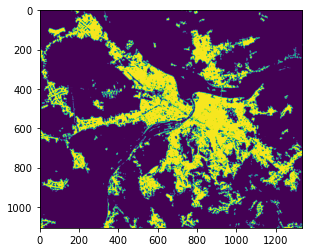

<AxesSubplot:>

In [101]:
show(wsf_)

In [112]:
wsf_clip = (wsf_, shifted_affine)

In [113]:
wsf_clip[0].shape

(1107, 1336)

In [139]:
# This calculates the change from 1990 and 2000
lei_raw = lei.calculate_LEI(wsf_clip, old_list = list(range(1985,1991)), new_list=list(range(1991,2001)))
lei_90_00 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
lei_90_00['LEI'] = lei_90_00['old'] / lei_90_00['total']      
lei_90_00.head()

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2257112.2935790159 5608077.6123517687 at 2257112.2935790159 5608077.6123517687
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256722.3999583512 5607829.4982295278 at 2256722.3999583512 5607829.4982295278
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2258069.3051933749 5607900.3879787391 at 2258069.3051933749 5607900.3879787391
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2255304.6049741157 5606305.3686214751 at 2255304.6049741157 5606305.3686214751
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2250732.2161499565 5605950.919875416 at 2250732.2161499565 5605950.919875416
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2253213.3573723687 5604887.5736372396 at 2253213.3573723687 5604887.5736372396
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287382.216492441 5587519.5850803554 at 2287382.216492441 5587519.5850803554
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2251441.1136420742 5586030.9003469087 at 2251441.1136420742 5586030.9003469087
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2266895.07897024 5585676.4516008496 at 2266895.07897024 5585676.4516008496
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287878.4447369236 5585853.6759738792 at 2287878.4447369236 5585853.6759738792
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2289402.5743449768 5585109.3336071558 at 2289402.5743449768 5585109.3336071558
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2284192.1777779115 5584790.3297357028 at 2284192.1777779115 5584790.3297357028
TopologyException: Input geo

,geometry,old,total,LEI
0,"POLYGON ((2275437.293750258 5609637.186834428,...",92,179,0.513966
1,"POLYGON ((2260054.218171304 5609601.741959821,...",2,166,0.012048
2,"POLYGON ((2275579.073248682 5609601.741959821,...",89,166,0.536145
3,"POLYGON ((2275791.742496317 5609601.741959821,...",45,166,0.271084
4,"POLYGON ((2274799.286007352 5609566.297085216,...",0,221,0.000000


In [150]:
lei_90_00["city"] = "Belgrade"

In [153]:
summary = lei.summarize_LEI(lei_90_00, leap_val=0.05, exp_val=0.75)/1000000

In [179]:
lei_90_00_res = []
lei_90_00_sum = []

for idx, row in cities.iterrows():
    geometry = row['geometry']
    # get pixel coordinates of the geometry's bounding box
    ul = wsf.index(*geometry.bounds[0:2])
    lr = wsf.index(*geometry.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
    t = wsf.transform
    shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)
    wsf_ = wsf.read(1, window = window)
    wsf_clip = (wsf_, shifted_affine)
    
    # This calculates the change from 1990 and 2000
    lei_raw = lei.calculate_LEI(wsf_clip, old_list = list(range(1985,1991)), new_list=list(range(1991,2001)))
    lei_90_00 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
    lei_90_00['LEI'] = lei_90_00['old'] / lei_90_00['total']
    lei_90_00['city'] = row.city
    lei_90_00_res.append(lei_90_00)
    
    summary = lei.summarize_LEI(lei_90_00, leap_val=0.05, exp_val=0.75)
    summary.name = row.city
    lei_90_00_sum.append(summary)

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2257112.2935790159 5608077.6123517687 at 2257112.2935790159 5608077.6123517687
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256722.3999583512 5607829.4982295278 at 2256722.3999583512 5607829.4982295278
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2258069.3051933749 5607900.3879787391 at 2258069.3051933749 5607900.3879787391
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2255304.6049741157 5606305.3686214751 at 2255304.6049741157 5606305.3686214751
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2250732.2161499565 5605950.919875416 at 2250732.2161499565 5605950.919875416
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2253213.3573723687 5604887.5736372396 at 2253213.3573723687 5604887.5736372396
TopologyException: Input

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287382.216492441 5587519.5850803554 at 2287382.216492441 5587519.5850803554
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2251441.1136420742 5586030.9003469087 at 2251441.1136420742 5586030.9003469087
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2266895.07897024 5585676.4516008496 at 2266895.07897024 5585676.4516008496
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287878.4447369236 5585853.6759738792 at 2287878.4447369236 5585853.6759738792
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2289402.5743449768 5585109.3336071558 at 2289402.5743449768 5585109.3336071558
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2284192.1777779115 5584790.3297357028 at 2284192.1777779115 5584790.3297357028
TopologyException: Input geo

In [197]:
summary1 = pd.DataFrame(lei_90_00_sum)/1000000
summary1.columns.name = "1985 to 2000"

In [188]:
lei_00_14_res = []
lei_00_14_sum = []

for idx, row in cities.iterrows():
    geometry = row['geometry']
    # get pixel coordinates of the geometry's bounding box
    ul = wsf.index(*geometry.bounds[0:2])
    lr = wsf.index(*geometry.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
    t = wsf.transform
    shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)
    wsf_ = wsf.read(1, window = window)
    wsf_clip = (wsf_, shifted_affine)

    # This calculates the change from 2000 and 2015
    lei_raw = lei.calculate_LEI(wsf_clip, old_list = list(range(1985,2001)), new_list=list(range(2001,2016)))
    lei_00_14 = pd.DataFrame(lei_raw, columns=['geometry', 'old', 'total'])
    lei_00_14['LEI'] = lei_00_14['old'] / lei_00_14['total']
    lei_00_14['city'] = row.city
    lei_00_14_res.append(lei_00_14)
    
    summary = lei.summarize_LEI(lei_00_14, leap_val=0.05, exp_val=0.75)
    summary.name = row.city
    lei_00_14_sum.append(summary)

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256722.3999583512 5608538.3957216451 at 2256722.3999583512 5608538.3957216451
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2255127.3806010862 5607581.3841072861 at 2255127.3806010862 5607581.3841072861
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2256616.0653345333 5606837.0417405628 at 2256616.0653345333 5606837.0417405628
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2250519.5469023213 5606128.1442484455 at 2250519.5469023213 5606128.1442484455
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2250271.43278008 5605667.3608785691 at 2250271.43278008 5605667.3608785691
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2251122.1097706216 5605348.3570071161 at 2251122.1097706216 5605348.3570071161
TopologyException: Input g

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2285042.8547684527 5590851.4032933088 at 2285042.8547684527 5590851.4032933088
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2287134.1023702002 5591134.9622901557 at 2287134.1023702002 5591134.9622901557
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2263456.9261334692 5590567.8442964619 at 2263456.9261334692 5590567.8442964619
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2262960.6978889867 5590603.289171068 at 2262960.6978889867 5590603.289171068
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2265831.7327320636 5590284.285299615 at 2265831.7327320636 5590284.285299615
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2285113.7445176644 5590709.6237948854 at 2285113.7445176644 5590709.6237948854
TopologyException: Input g

TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2441850.9800248854 5359715.3759883363 at 2441850.9800248854 5359715.3759883363
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2445856.2508553504 5358510.2502517365 at 2445856.2508553504 5358510.2502517365
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2439511.6183008971 5356596.2270230185 at 2439511.6183008971 5356596.2270230185
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2330624.9635116202 5469488.1526427595 at 2330624.9635116202 5469488.1526427595
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2332078.2033704612 5467893.1332854955 at 2332078.2033704612 5467893.1332854955
TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point 2323287.8744682022 5464951.2086932063 at 2323287.8744682022 5464951.2086932063
TopologyException: Inp

In [207]:
summary2 = pd.DataFrame(lei_00_14_sum)/1000000
summary2.columns.name = "2000 to 2015"

In [213]:
lei_summary_cities = pd.concat([summary1, summary2], axis=1)

In [214]:
lei_summary_cities.to_csv(os.path.join(out_dir, "Landscape Expansion Index Summary Cities.csv"))

In [217]:
lei_90_00_res2 = pd.concat(lei_90_00_res)

In [222]:
lei_90_00_res2.to_csv(os.path.join(out_dir, "lei_85_00_cities.csv"))

In [223]:
lei_00_14_res2 = pd.concat(lei_00_14_res)

In [224]:
lei_00_14_res2.to_csv(os.path.join(out_dir, "lei_00_15_cities.csv"))

In [225]:
wsf.crs

CRS.from_epsg(3857)

## Clip Nighttime lights rasters

In [40]:
viirs_2012 = '/home/public/Data/GLOBAL/NighttimeLights/VIIRS_ANNUAL_EOG/VNL_v2_npp_201204-201212_global_vcmcfg_c202101211500.average_masked.tif'
viirs_2020 = '/home/public/Data/GLOBAL/NighttimeLights/VIIRS_ANNUAL_EOG/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.average_masked.tif'
viirs_2019 = '/home/public/Data/GLOBAL/NighttimeLights/VIIRS_ANNUAL_EOG/VNL_v2_npp_2019_global_vcmslcfg_c202102150000.average_masked.tif'

In [26]:
# clip from global GHSL file
in_viirs = rio.open(viirs_2012)
if not inB.crs == in_viirs.crs:
    inB = inB.to_crs(in_viirs.crs.to_string())

In [30]:
out_viirs = os.path.join(out_dir, "NTL_2012.tif")
rMisc.clipRaster(in_viirs, inB, out_viirs)

In [31]:
# clip from global GHSL file
in_viirs = rio.open(viirs_2020)
if not inB.crs == in_viirs.crs:
    inB = inB.to_crs(in_viirs.crs.to_string())

In [32]:
out_viirs = os.path.join(out_dir, "NTL_2020.tif")
rMisc.clipRaster(in_viirs, inB, out_viirs)

In [41]:
# clip from global GHSL file
in_viirs = rio.open(viirs_2019)
if not inB.crs == in_viirs.crs:
    inB = inB.to_crs(in_viirs.crs.to_string())

In [42]:
out_viirs = os.path.join(out_dir, "NTL_2019.tif")
rMisc.clipRaster(in_viirs, inB, out_viirs)

In [35]:
gdp = '/home/public/Data/GLOBAL/ECON/PPP2005/ppp2005sum.asc'

In [37]:
# clip from global GHSL file
in_gdp = rio.open(gdp)

In [39]:
in_gdp.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 360,
 'height': 140,
 'count': 1,
 'crs': None,
 'transform': Affine(1.0, 0.0, -180.0,
        0.0, -1.0, 84.0)}

## ESA Land Cover Change Analysis

In [8]:
from rasterstats import zonal_stats
from shapely.wkt import loads
import numpy as np

In [15]:
cci_15_tif = "/home/public/Data/GLOBAL/LANDCOVER/GLOBCOVER/2015/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"
in_cci_15 = rio.open(cci_15_tif)
if not inB.crs == in_cci_15.crs:
    inB = inB.to_crs(in_cci_15.crs.to_string())

In [18]:
input_cci_15 = os.path.join(out_dir, "LC_2015.tif")
rMisc.clipRaster(in_cci_15, inB, input_cci_15)

In [44]:
cci_00_tif = os.path.join(out_dir, "LC_2000.tif")
in_cci_00 = rio.open(cci_00_tif)

In [51]:
input_cci_00 = os.path.join(out_dir, "LC_2000_SRB.tif")
rMisc.clipRaster(in_cci_00, inB, input_cci_00)

In [9]:
input_cci_15 = os.path.join(out_dir, "LC_2015.tif")
input_cci_00 = os.path.join(out_dir, "LC_2000_SRB.tif")

In [27]:
cci_15 = rio.open(input_cci_15)
cci_15_ = cci_15.read(1)

In [28]:
cci_00 = rio.open(input_cci_00)
cci_00_ = cci_00.read(1)

In [31]:
cci_dict = {
    1:'agriculture',
    2:"trees",
    3:"natural vegetation",
    4:"urban",
    5:"bare land",
    6:"water bodies",
    7:"ice/snow"
}

In [13]:
# cci_dict = {
#     1:'trees',
#     2:"shrubs",
#     3:"grasslands",
#     4:"cropland",
#     5:"vegetation aquatic",
#     6:"sparse vegetation",
#     7:"bare areas",
#     8:"built up",
#     10:"water"
# }

In [32]:
cci_15_[((cci_15_ > 0) & (cci_15_ < 50))] = 1
cci_15_[((cci_15_ > 40) & (cci_15_ < 110))] = 2
cci_15_[((cci_15_ > 155) & (cci_15_ < 175))] = 2
cci_15_[((cci_15_ > 100) & (cci_15_ < 190))] = 3
cci_15_[(cci_15_ == 190)] = 4
cci_15_[((cci_15_ > 140) & (cci_15_ < 205))] = 5
cci_15_[(cci_15_ == 210)] = 6
cci_15_[(cci_15_ == 220)] = 7

In [33]:
cci_00_[((cci_00_ > 0) & (cci_00_ < 50))] = 1
cci_00_[((cci_00_ > 40) & (cci_00_ < 110))] = 2
cci_00_[((cci_00_ > 155) & (cci_00_ < 175))] = 2
cci_00_[((cci_00_ > 100) & (cci_00_ < 190))] = 3
cci_00_[(cci_00_ == 190)] = 4
cci_00_[((cci_00_ > 140) & (cci_00_ < 205))] = 5
cci_00_[(cci_00_ == 210)] = 6
cci_00_[(cci_00_ == 220)] = 7

In [34]:
np.unique(cci_15_)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [35]:
np.unique(cci_00_)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [36]:
cci_15_.shape == cci_00_.shape

True

In [63]:
lei_90_00 = pd.read_csv(os.path.join(out_dir, "lei_85_00_cities.csv"))
lei_00_14 = pd.read_csv(os.path.join(out_dir, "lei_00_15_cities.csv"), index_col=0)

In [74]:
lei_00_14.loc[:, "geometry"] = lei_00_14.loc[:, "geometry"].apply(lambda x: loads(x))

In [78]:
lei_00_14 = gpd.GeoDataFrame(lei_00_14, crs='EPSG:3857')

In [82]:
cci_15.crs.to_string()

'EPSG:4326'

In [83]:
lei_00_14 = lei_00_14.to_crs(cci_15.crs.to_string())

In [87]:
zs_00 = pd.DataFrame(zonal_stats(lei_00_14, cci_00_, affine=cci_00.transform, nodata=0, categorical=True, category_map=cci_dict))
# zs_15 = pd.DataFrame(zonal_stats(lei_00_14, cci_15_, affine=cci_15.transform, nodata=0, categorical=True, category_map=cci_dict))

Try Resampling

In [173]:
from rasterio.enums import Resampling

In [174]:
upscale_factor = 20

with rio.open(input_cci_00) as dataset:

    # resample data to target shape
    cci_00_re = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.nearest
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / cci_00_re.shape[-1]),
        (dataset.height / cci_00_re.shape[-2])
    )

In [175]:
cci_00_re[((cci_00_re > 0) & (cci_00_re < 50))] = 1
cci_00_re[((cci_00_re > 40) & (cci_00_re < 110))] = 2
cci_00_re[((cci_00_re > 155) & (cci_00_re < 175))] = 2
cci_00_re[((cci_00_re > 100) & (cci_00_re < 190))] = 3
cci_00_re[(cci_00_re == 190)] = 4
cci_00_re[((cci_00_re > 140) & (cci_00_re < 205))] = 5
cci_00_re[(cci_00_re == 210)] = 6
cci_00_re[(cci_00_re == 220)] = 7

In [176]:
zs_00_re = pd.DataFrame(zonal_stats(lei_00_14, cci_00_re[0,:,:], affine=transform, nodata=0, categorical=True, category_map=cci_dict))

In [178]:
max_00 = zs_00_re.idxmax(axis=1)

In [183]:
upscale_factor = 20

with rio.open(input_cci_15) as dataset:

    # resample data to target shape
    cci_15_re = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.nearest
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / cci_15_re.shape[-1]),
        (dataset.height / cci_15_re.shape[-2])
    )

In [184]:
cci_15_re[((cci_15_re > 0) & (cci_15_re < 50))] = 1
cci_15_re[((cci_15_re > 40) & (cci_15_re < 110))] = 2
cci_15_re[((cci_15_re > 155) & (cci_15_re < 175))] = 2
cci_15_re[((cci_15_re > 100) & (cci_15_re < 190))] = 3
cci_15_re[(cci_15_re == 190)] = 4
cci_15_re[((cci_15_re > 140) & (cci_15_re < 205))] = 5
cci_15_re[(cci_15_re == 210)] = 6
cci_15_re[(cci_15_re == 220)] = 7

In [185]:
zs_15_re = pd.DataFrame(zonal_stats(lei_00_14, cci_15_re[0,:,:], affine=transform, nodata=0, categorical=True, category_map=cci_dict))

In [186]:
max_15 = zs_15_re.idxmax(axis=1)

In [192]:
lei_00_14.loc[:, "lc_00"] = max_00
lei_00_14.loc[:, "lc_15"] = max_15

In [194]:
lei_00_14_cop = lei_00_14.drop('geometry', axis=1)

In [196]:
lei_00_14_cop.to_csv(os.path.join(out_dir, "lei_00_15_cities_lc.csv"))

Entire country

In [37]:
indices = list(np.ndindex(cci_00_.shape))

In [38]:
xys = [cci_00.xy(ind[0], ind[1]) for ind in indices]

In [39]:
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'cci_00': cci_00_.flatten(),
    'cci_15': cci_15_.flatten()
})

In [40]:
300*300

90000

In [41]:
res_df.loc[:, "area"] = 0.09

In [42]:
res_df.cci_00.unique()

array([0, 1, 2, 3, 6, 4, 5], dtype=uint8)

In [45]:
len(res_df)

2133296

In [46]:
res_df = res_df.loc[res_df.cci_00>0].copy()

In [47]:
len(res_df)

1131886

In [ ]:
cci_dict = {
    1:'agriculture',
    2:"trees",
    3:"natural vegetation",
    4:"urban",
    5:"bare land",
    6:"water bodies",
    7:"ice/snow"
}

In [48]:
res_df.loc[:, "cci_00"] = res_df.cci_00.apply(lambda x: cci_dict[x])
res_df.loc[:, "cci_15"] = res_df.cci_15.apply(lambda x: cci_dict[x])

In [53]:
res_df.loc[:, "change"] = 0

In [58]:
res_df.loc[res_df.cci_00!=res_df.cci_15, "change"] = 1

In [60]:
res_df.loc[:, "transition"] = ""

In [63]:
# for idx, row in res_df.iterrows():
#     if row.change == 0:
#         res_df.loc[idx, "transition"] = "No change"
#     else:
#         res_df.loc[idx, "transition"] = row.cci_00 + " to " + row.cci_15

In [66]:
res_df.loc[res_df.change==0, "transition"] = "No change"

In [74]:
res_df.loc[:, "transition"] = res_df.cci_00 + " to " + res_df.cci_15

In [75]:
res_df.loc[res_df.change==0, "transition"] = "No change"

In [86]:
os.chdir(out_dir)

In [91]:
res_df.cci_00.value_counts().to_csv("National CCI 00.csv")

In [92]:
res_df.cci_15.value_counts().to_csv("National CCI 15.csv")

In [96]:
res_df.groupby('transition').count().area.to_csv("National CCI Transition.csv")

In [93]:
# res_df.groupby('transition').sum().to_csv("National CCI Transition.csv")

In [51]:
# res_df.to_csv("National Summary CCI.csv")